In [1]:
!which python

/home/user/jfayzullaev/stellar-clustering/.venv-vis/bin/python


In [2]:
import re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

In [3]:
TL_EMB  = "../tl_node2vec_dbscan_cosine_pca64_kgrid_test.csv"

In [4]:

TL_EDGES = "~/stellar-clustering/network/data/trustline_edges_mv.csv" 

In [5]:
PROJ_PKL = os.path.expanduser("~/stellar-clustering/network/LCC/trustlines/trust_proj_LCC_idf.pkl")

In [6]:
MS  = 5
EPS = 0.168

In [7]:
label_pat = re.compile(rf"^dbscan.*ms[_-]?{MS}.*eps[_-]?0?{str(EPS).rstrip('0')}$")

In [ ]:
usecols = ["account_id"]
df_head = pd.read_csv(TL_EMB, nrows=1)
candidates = [c for c in df_head.columns if c.lower().startswith("dbscan")]

label_col = None
for c in candidates:
    c_norm = c.lower().replace(" ", "")
    if label_pat.search(c_norm):
        label_col = c
        break

if label_col is None:
    eps_token = str(EPS).rstrip("0").rstrip(".")
    loose = [c for c in candidates if f"ms{MS}" in c.lower().replace("_","").replace("-","")
                                  and f"eps_{eps_token}" in c.lower()]
    if loose:
        label_col = loose[0]

if label_col is None:
    raise ValueError(
        f"no col for ms={MS}, eps={EPS}.\n"
        f"Found columns: {candidates}"
    )

In [9]:
tx_df = pd.read_csv(TL_EMB, usecols=["account_id", label_col])
tx_df["account_id"] = tx_df["account_id"].astype("int64")
tx_df.rename(columns={label_col: "dbscan_label"}, inplace=True)

In [10]:
# edges = pd.read_csv(TL_EDGES, usecols=["account_id", "issuer_id", "asset_code", "balance"])
# edges["account_id"] = edges["account_id"].astype("int64")
# edges["asset_node"] = edges["issuer_id"].astype(str) + ":" + edges["asset_code"].astype(str)

In [11]:
with open(PROJ_PKL, "rb") as f:
    G_tl = pickle.load(f)

print(f"Projected graph: {G_tl.number_of_nodes():,} nodes, {G_tl.number_of_edges():,} edges")
if G_tl.number_of_edges() > 0:
    avg_deg = 2 * G_tl.number_of_edges() / G_tl.number_of_nodes()
    print(f"Average degree: {avg_deg:.2f}")

Projected graph: 24,586 nodes, 210,923 edges
Average degree: 17.16


In [ ]:
labels_map = dict(tx_df.itertuples(index=False, name=None))
nx.set_node_attributes(G_tl, {n: {"dbscan_label": labels_map.get(n, -1)} for n in G_tl.nodes})

vals = tx_df["dbscan_label"].value_counts(dropna=False)
print(f"\nAttached DBSCAN labels (ms={MS}, eps={EPS}) to projected graph nodes.")
print("Label distribution (including noise=-1):")
print(vals.head(15))

## Top-5 clusters 

In [13]:
def top5_sizes(df, label_col, exclude_noise=True, noise_label=-1):
    total = len(df)
    s = df[label_col].value_counts().rename_axis("cluster_id").reset_index(name="n_accounts")
    if exclude_noise:
        s = s[s["cluster_id"] != noise_label]
    s = s.sort_values("n_accounts", ascending=False).head(5).copy()
    s["pct_of_all"] = (s["n_accounts"] / total * 100).round(2)
    s.insert(0, "label_col", label_col)
    return s

In [14]:
def per_cluster_stats(df, label_col, G, top_ids):

    rows = []
    nodes_in_G = set(G.nodes)
    total = len(df)

    for cid in top_ids:
        comm_nodes = set(df.loc[df[label_col] == cid, "account_id"])
        comm_nodes_in_G = list(comm_nodes & nodes_in_G)

        sub = G.subgraph(comm_nodes_in_G).copy()
        n_nodes = sub.number_of_nodes()
        n_edges = sub.number_of_edges()
        density = nx.density(sub) if n_nodes > 1 else 0.0
        avg_degree = (sum(dict(sub.degree()).values()) / n_nodes) if n_nodes > 0 else 0.0

        rows.append({
            "label_col": label_col,
            "cluster_id": cid,
            "size_in_partition": len(comm_nodes),           
            "size_in_graph": n_nodes,                  
            "edges_in_graph": n_edges,
            "density": density,
            "avg_degree": avg_degree,
            "pct_of_all_nodes": round(len(comm_nodes) / total * 100, 2),
        })

    return pd.DataFrame(rows).sort_values("size_in_graph", ascending=False)


In [15]:
tx_top5 = top5_sizes(tx_df, label_col="dbscan_label", exclude_noise=True, noise_label=-1)
top_ids = tx_top5["cluster_id"].tolist()
tx_stats = per_cluster_stats(tx_df, label_col="dbscan_label", G=G_tl, top_ids=top_ids)

print(f"Trustlines — Top 5 clusters (DBSCAN ms={MS}, eps={EPS}):")
display(tx_top5)



Trustlines — Top 5 clusters (DBSCAN ms=5, eps=0.168):


,label_col,cluster_id,n_accounts,pct_of_all
0,dbscan_label,0,22102,89.90
2,dbscan_label,1,61,0.25
3,dbscan_label,13,34,0.14
4,dbscan_label,3,27,0.11
5,dbscan_label,4,26,0.11


In [16]:
print("\nPer-cluster graph stats for those Top 5:")
display(tx_stats)


Per-cluster graph stats for those Top 5:


,label_col,cluster_id,size_in_partition,size_in_graph,edges_in_graph,density,avg_degree,pct_of_all_nodes
0,dbscan_label,0,22102,22102,151481,0.000620,13.707447,89.90
1,dbscan_label,1,61,61,233,0.127322,7.639344,0.25
2,dbscan_label,13,34,34,182,0.324421,10.705882,0.14
3,dbscan_label,3,27,27,232,0.660969,17.185185,0.11
4,dbscan_label,4,26,26,200,0.615385,15.384615,0.11


### Plot the Degree Distribution for top 5 

In [ ]:
def plot_degree_hist_for_top5(G, df, top_table, label_col, bins=50):
    nodes_in_G = set(G.nodes)

    for cid in top_table["cluster_id"]:
        comm_nodes = set(df.loc[df[label_col] == cid, "account_id"])
        sub_nodes = list(comm_nodes & nodes_in_G)
        sub = G.subgraph(sub_nodes)

        degs = [d for _, d in sub.degree()]
        n = len(degs)

        zero_deg = sum(1 for d in degs if d == 0)
        zero_pct = 100.0 * zero_deg / n
        print(f"[{label_col}={cid}] n={n} | zero-degree={zero_deg} ({zero_pct:.2f}%)")

        if zero_deg == n:
            print(f"all nodes have degree 0")
            continue

        plt.figure(figsize=(6, 4))
        plt.hist(degs, bins=bins, edgecolor="black")
        plt.yscale("log")
        plt.xlabel("Degree (undirected)")
        plt.ylabel("Count")
        plt.title(f"TL degree distribution — {label_col} {cid} (n={n}, zero={zero_pct:.1f}%)")
        plt.tight_layout()
        plt.show()


[dbscan_label=0] n=22102 | zero-degree=492 (2.23%)


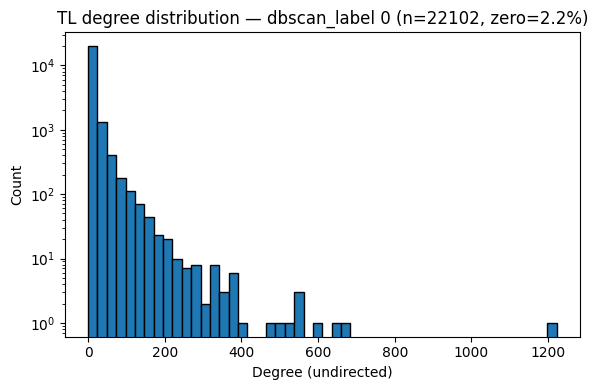

[dbscan_label=1] n=61 | zero-degree=0 (0.00%)


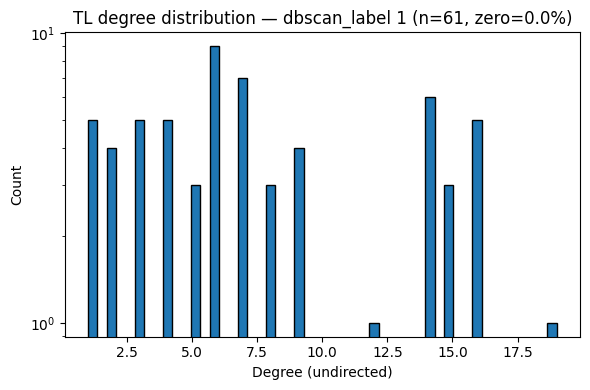

[dbscan_label=13] n=34 | zero-degree=0 (0.00%)


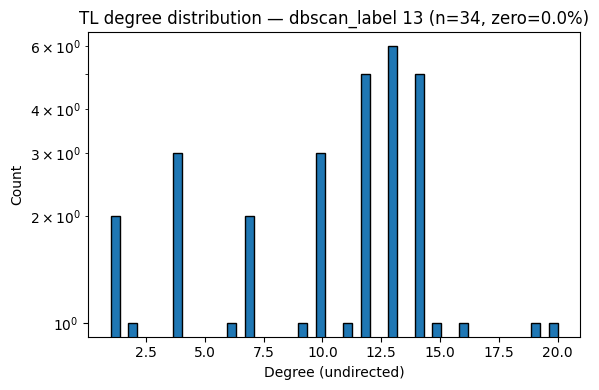

[dbscan_label=3] n=27 | zero-degree=0 (0.00%)


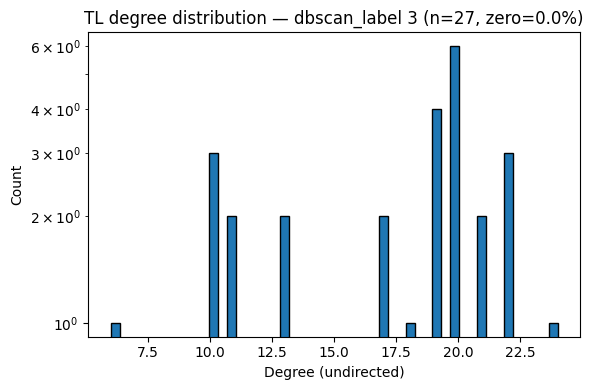

[dbscan_label=4] n=26 | zero-degree=0 (0.00%)


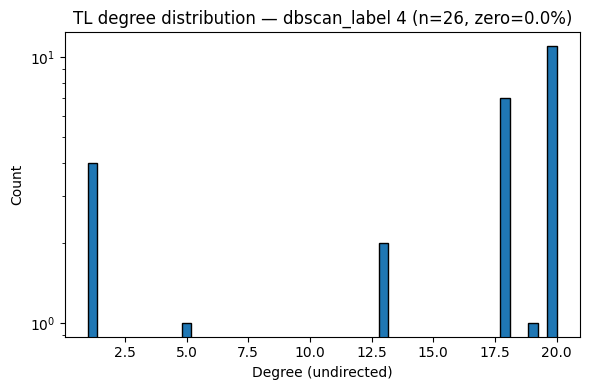

In [18]:
plot_degree_hist_for_top5(G_tl, tx_df, tx_top5, label_col="dbscan_label", bins=50)


[dbscan_label=0] n=22102 | zero-degree=492 (2.23%)
[dbscan_label=1] n=61 | zero-degree=0 (0.00%)
[dbscan_label=13] n=34 | zero-degree=0 (0.00%)
[dbscan_label=3] n=27 | zero-degree=0 (0.00%)
[dbscan_label=4] n=26 | zero-degree=0 (0.00%)


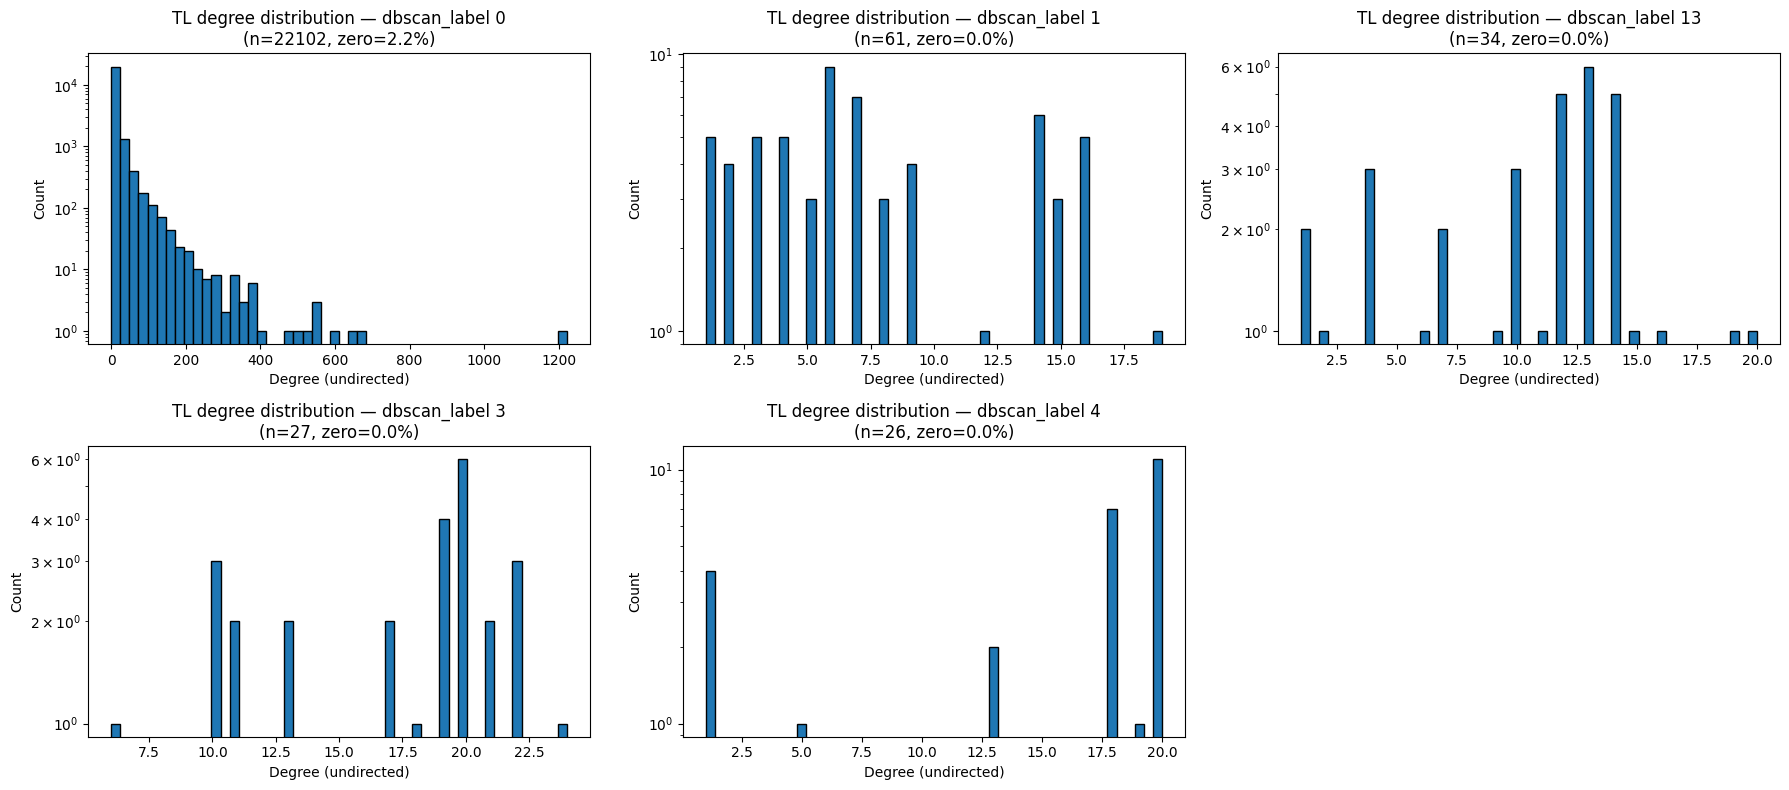

In [ ]:
import math

def plot_degree_hist_for_top5_one(
    G,
    df,
    top_table,
    label_col,
    bins=50,
    title_prefix="TL degree distribution"
):
    nodes_in_G = set(G.nodes)

    plots = []
    for cid in top_table["cluster_id"]:
        comm_nodes = set(df.loc[df[label_col] == cid, "account_id"])
        sub_nodes = list(comm_nodes & nodes_in_G)
        sub = G.subgraph(sub_nodes)

        degs = [d for _, d in sub.degree()]
        n = len(degs)

        zero_deg = sum(1 for d in degs if d == 0)
        zero_pct = 100.0 * zero_deg / n
        print(f"[{label_col}={cid}] n={n} | zero-degree={zero_deg} ({zero_pct:.2f}%)")

        plots.append((cid, degs, n, zero_pct))


    n_plots = len(plots)
    n_cols = min(3, n_plots)
    n_rows = math.ceil(n_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
    if n_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for ax, (cid, degs, n, zero_pct) in zip(axes, plots):
        ax.hist(degs, bins=bins, edgecolor="black")
        ax.set_yscale("log")
        ax.set_xlabel("Degree (undirected)")
        ax.set_ylabel("Count")
        ax.set_title(f"{title_prefix} — {label_col} {cid}\n"
                     f"(n={n}, zero={zero_pct:.1f}%)")

    for ax in axes[n_plots:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

plot_degree_hist_for_top5_one(
    G_tl,
    tx_df,
    tx_top5,
    label_col="dbscan_label",
    bins=50,
    title_prefix="TL degree distribution"
)


### Bind to metadata

In [20]:
NODES_CSV   = os.path.expanduser("~/stellar-clustering/network/data/new/account_nodes_all_mv.csv")
FEATS_CSV   = os.path.expanduser("~/stellar-clustering/network/data/new/account_node_features_full_mv.csv")

In [21]:
LABEL_COL = "dbscan_label" 

In [22]:
assert {"account_id", LABEL_COL}.issubset(tx_df.columns), \
    f"tx_df must include 'account_id' and '{LABEL_COL}'. Got: {list(tx_df.columns)}"

In [23]:
df_nodes = pd.read_csv(NODES_CSV, usecols=["account_id"])
df_meta  = pd.read_csv(FEATS_CSV)

In [24]:
tx_df["account_id"] = tx_df["account_id"].astype("int64", errors="ignore")
if "account_id" in df_nodes.columns:
    df_nodes["account_id"] = df_nodes["account_id"].astype("int64", errors="ignore")
df_meta["account_id"] = df_meta["account_id"].astype("int64", errors="ignore")

In [25]:
if df_meta.index.duplicated().any() or df_meta["account_id"].duplicated().any():
    df_meta = df_meta.drop_duplicates(subset=["account_id"])

In [26]:
df_comm = tx_df[["account_id", LABEL_COL]].copy()
df_merged = df_comm.merge(df_meta, on="account_id", how="left")

In [ ]:
print(df_merged.head(10))

In [28]:
overlap = df_comm["account_id"].isin(df_meta["account_id"]).sum()
print(f"Matched account IDs: {overlap} / {len(df_comm)}")

Matched account IDs: 24586 / 24586


In [29]:
out_csv = "tl_dbscan_with_metadata.csv"
df_merged.to_csv(out_csv, index=False)
print(f"Saved: {out_csv}")

Saved: tl_dbscan_with_metadata.csv


In [30]:
df_with_metadata = df_merged[df_merged["address"].notna()].copy()

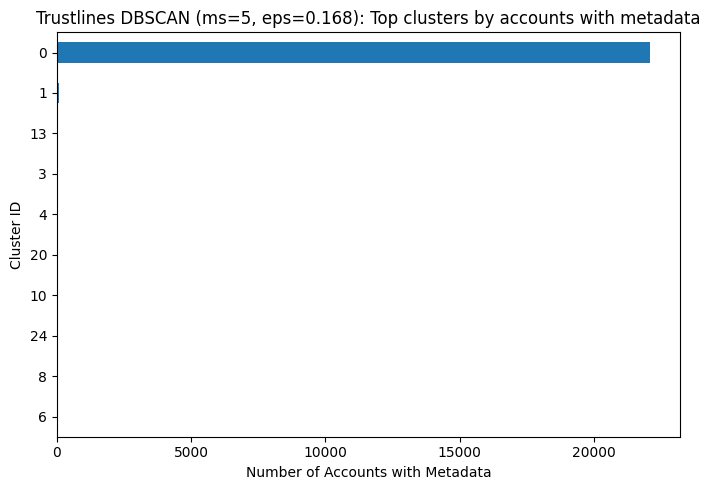

In [ ]:
counts = (
    df_with_metadata[LABEL_COL]
    .value_counts()
)
counts = counts[counts.index != -1]
top_counts = counts.head(10).sort_values(ascending=True)

plt.figure(figsize=(7, 5))
top_counts.plot(kind="barh", title=f"Trustlines DBSCAN (ms={MS}, eps={EPS}): Top clusters by accounts with metadata")
plt.xlabel("Number of Accounts with Metadata")
plt.ylabel("Cluster ID")
plt.tight_layout()
plt.show()

### Bind with the normalized labels

In [32]:
NORM_LABELS = os.path.expanduser("~/stellar-clustering/network/labled-data/labels/label-normalization/labels_entities_normalized.csv")

In [33]:
df_norm = (
    pd.read_csv(NORM_LABELS, usecols=["account_id", "name"])
      .dropna(subset=["account_id", "name"])
      .drop_duplicates(subset=["account_id"])
      .rename(columns={"name": "entity"})
)

In [34]:
for col in ["account_id"]:
    try:
        tx_df[col] = tx_df[col].astype("Int64")
        df_norm[col] = df_norm[col].astype("Int64")
    except Exception:
        tx_df[col] = tx_df[col].astype(str)
        df_norm[col] = df_norm[col].astype(str)


In [ ]:
def bind_and_plot_dbscan(tx_df, df_norm, label_col):

    assert {"account_id", label_col}.issubset(tx_df.columns), \
        f"tx_df must have columns 'account_id' and '{label_col}'"

    df_comm = tx_df[["account_id", label_col]].copy()
    df_matched = df_comm.merge(df_norm, on="account_id", how="inner")

    match_rate = len(df_matched) / max(len(df_comm), 1)
    print(f"[{label_col}] Matched accs: {len(df_matched):,} / {len(df_comm):,} ({match_rate:.2%})")

    return df_matched


In [ ]:
tx_matched_dbscan = bind_and_plot_dbscan(tx_df, df_norm, label_col="dbscan_label")

entity breakdown 

In [37]:
def entity_breakdown_dbscan(df_matched, label_col, topn=5, exclude_noise=True, noise_label=-1):

    assert {"entity", label_col}.issubset(df_matched.columns), \
        f"df_matched must include 'entity' and '{label_col}'"

    work = df_matched if not exclude_noise else df_matched[df_matched[label_col] != noise_label]


    label_counts = (
        work.groupby([label_col, "entity"])
            .size()
            .reset_index(name="count")
    )


    top_clusters = (
        label_counts.groupby(label_col)["count"]
            .sum()
            .sort_values(ascending=False)
            .head(topn)
            .index
            .tolist()
    )

    for cid in top_clusters:
        sub = label_counts[label_counts[label_col] == cid].copy()
        total_c = sub["count"].sum()
        sub["share"] = (sub["count"] / total_c).round(3)

        print(f"\nCluster {cid} — {label_col} — normalized entity breakdown (n={total_c}):")
        try:
            display(sub.sort_values("count", ascending=False))
        except NameError:
            print(sub.sort_values("count", ascending=False).to_string(index=False))


In [38]:
entity_breakdown_dbscan(tx_matched_dbscan, label_col="dbscan_label", topn=5, exclude_noise=True)


Cluster 0 — dbscan_label — normalized entity breakdown (n=124):


,dbscan_label,entity,count,share
8,0,SCAM,112,0.903
9,0,TMM bot,3,0.024
0,0,Bitfinex,1,0.008
2,0,Centre,1,0.008
1,0,Bitmart,1,0.008
3,0,IndoDax,1,0.008
4,0,KuCoin,1,0.008
6,0,MEXC,1,0.008
5,0,Lobstr,1,0.008
7,0,Mercado Bitcoin,1,0.008



Cluster 32 — dbscan_label — normalized entity breakdown (n=2):


,dbscan_label,entity,count,share
13,32,GoodX,1,0.5
14,32,HitBTC,1,0.5



Cluster 16 — dbscan_label — normalized entity breakdown (n=1):


,dbscan_label,entity,count,share
11,16,Centre,1,1.0



Cluster 28 — dbscan_label — normalized entity breakdown (n=1):


,dbscan_label,entity,count,share
12,28,SCAM,1,1.0


In [ ]:
import pandas as pd

def entity_breakdown_dbscan_table(
    df_matched,
    label_col,
    topn=5,
    exclude_noise=True,
    noise_label=-1
):

    assert {"entity", label_col}.issubset(df_matched.columns), \
        f"df_matched must include 'entity' and '{label_col}'"

    if exclude_noise:
        work = df_matched[df_matched[label_col] != noise_label].copy()
    else:
        work = df_matched.copy()

    label_counts = (
        work
        .groupby([label_col, "entity"])
        .size()
        .reset_index(name="count")
    )

    top_clusters = (
        label_counts
        .groupby(label_col)["count"]
        .sum()
        .sort_values(ascending=False)
        .head(topn)
        .index
        .tolist()
    )

    table_top = (
        label_counts[label_counts[label_col].isin(top_clusters)]
        .copy()
    )

    table_top = (
        table_top
        .sort_values(["count"], ascending=[False])
        .reset_index(drop=True)
    )

    try:
        display(table_top)
    except NameError:
        print(table_top.to_string(index=False))

    return table_top

table_top = entity_breakdown_dbscan_table(
    df_matched=tx_matched_dbscan,
    label_col="dbscan_label",
    topn=5,
    exclude_noise=True,
    noise_label=-1
)


,dbscan_label,entity,count
0,0,SCAM,112
1,0,TMM bot,3
2,0,Bitfinex,1
3,0,IndoDax,1
4,0,KuCoin,1
5,0,Bitmart,1
6,0,Centre,1
7,0,MEXC,1
8,0,Lobstr,1
9,0,Mercado Bitcoin,1


In [ ]:

def dbscan_coverage_analysis(df, label_col, noise_label=-1):

    total = len(df)
    clustered = len(df[df[label_col] != noise_label])
    noise = len(df[df[label_col] == noise_label])
    
    coverage_pct = (clustered / total) * 100
    noise_pct = (noise / total) * 100
    
    n_clusters = df[df[label_col] != noise_label][label_col].nunique()
    
    print(f"\n{'='*60}")
    print(f"DBSCAN Coverage Analysis (ms={MS}, eps={EPS})")
    print(f"{'='*60}")
    print(f"Total accounts: {total:,}")
    print(f"Clustered (core + border): {clustered:,} ({coverage_pct:.2f}%)")
    print(f"Noise points: {noise:,} ({noise_pct:.2f}%)")
    print(f"Number of clusters: {n_clusters}")
    print(f"{'='*60}\n")
    
    if 'entity' in df.columns:
        labeled_total = df['entity'].notna().sum()
        labeled_clustered = df[(df[label_col] != noise_label) & (df['entity'].notna())].shape[0]
        labeled_noise = df[(df[label_col] == noise_label) & (df['entity'].notna())].shape[0]
        
        print(f"Of {labeled_total:,} labeled accounts:")
        print(f"  - Clustered: {labeled_clustered:,} ({labeled_clustered/labeled_total*100:.2f}%)")
        print(f"  - Noise: {labeled_noise:,} ({labeled_noise/labeled_total*100:.2f}%)")
    
    return {
        'total': total,
        'clustered': clustered,
        'noise': noise,
        'coverage_pct': coverage_pct,
        'n_clusters': n_clusters
    }

# Run it
coverage_stats = dbscan_coverage_analysis(df_merged, label_col="dbscan_label", noise_label=-1)


DBSCAN Coverage Analysis (ms=5, eps=0.168)
Total accounts: 24,586
Clustered (core + border): 22,542 (91.69%)
Noise points: 2,044 (8.31%)
Number of clusters: 35



In [49]:
edges = pd.read_csv(TL_EDGES, usecols=["account_id", "issuer_id", "asset_code"])

for cid in [0, 1, 13, 3, 4]:
    cluster_accounts = tx_df[tx_df['dbscan_label'] == cid]['account_id']
    cluster_edges = edges[edges['account_id'].isin(cluster_accounts)]
    
    print(f"\nCluster {cid} - Top Assets:")
    top_assets = cluster_edges['asset_code'].value_counts().head(5)
    for asset, count in top_assets.items():
        print(f"  {asset}: {count}")


Cluster 0 - Top Assets:
  XRP: 65243
  XDC: 35066
  GOLD: 34171
  SGB: 28699
  BTC: 23881

Cluster 1 - Top Assets:
  SSLX: 59
  AQUA: 48
  LMG: 30
  DRA: 24
  YBX: 21

Cluster 13 - Top Assets:
  yUSDC: 29
  yXLM: 23
  GROG: 21
  USDC: 19
  AQUA: 18

Cluster 3 - Top Assets:
  mZAR: 27
  yUSDC: 24
  ZAMOSBFL0001: 15
  BTC: 14
  yXLM: 14

Cluster 4 - Top Assets:
  RST: 25
  RIO: 22
  USD: 22
  LMX: 21
  USDC: 10


In [52]:

table_data = []

for cid in [0, 1, 13, 3, 4]:
    cluster_accounts = tx_df[tx_df['dbscan_label'] == cid]['account_id']
    cluster_edges = edges[edges['account_id'].isin(cluster_accounts)]
    

    cluster_size = len(cluster_accounts)
    total_trustlines = len(cluster_edges)
    

    top_assets = cluster_edges['asset_code'].value_counts().head(5)
    

    for rank, (asset, count) in enumerate(top_assets.items(), 1):
        table_data.append({
            'Cluster': cid,
            'Cluster Size': cluster_size,
            'Total Trustlines': total_trustlines,
            'Rank': rank,
            'Asset Code': asset,
            'Trustline Count': count,
            'Accounts with Asset': cluster_edges[cluster_edges['asset_code'] == asset]['account_id'].nunique()
        })


df_table = pd.DataFrame(table_data)



print("ASSET DISTRIBUTION ANALYSIS - TOP 5 ASSETS PER CLUSTER")

display(df_table)


ASSET DISTRIBUTION ANALYSIS - TOP 5 ASSETS PER CLUSTER


,Cluster,Cluster Size,Total Trustlines,Rank,Asset Code,Trustline Count,Accounts with Asset
0,0,22102,6813598,1,XRP,65243,14118
1,0,22102,6813598,2,XDC,35066,9084
2,0,22102,6813598,3,GOLD,34171,11296
3,0,22102,6813598,4,SGB,28699,10491
4,0,22102,6813598,5,BTC,23881,7580
5,1,61,1461,1,SSLX,59,59
6,1,61,1461,2,AQUA,48,48
7,1,61,1461,3,LMG,30,30
8,1,61,1461,4,DRA,24,24
9,1,61,1461,5,YBX,21,21


In [53]:
pivot_data = []
for cid in [0, 1, 13, 3, 4]:
    cluster_accounts = tx_df[tx_df['dbscan_label'] == cid]['account_id']
    cluster_edges = edges[edges['account_id'].isin(cluster_accounts)]
    
    cluster_size = len(cluster_accounts)
    top_assets = cluster_edges['asset_code'].value_counts().head(5)
    
    row = {
        'Cluster': cid,
        'Size': cluster_size,
        'Top 1': f"{top_assets.index[0]} ({top_assets.values[0]})",
        'Top 2': f"{top_assets.index[1]} ({top_assets.values[1]})",
        'Top 3': f"{top_assets.index[2]} ({top_assets.values[2]})",
        'Top 4': f"{top_assets.index[3]} ({top_assets.values[3]})",
        'Top 5': f"{top_assets.index[4]} ({top_assets.values[4]})"
    }
    pivot_data.append(row)

df_pivot = pd.DataFrame(pivot_data)


print("TOP 5 ASSETS PER CLUSTER")

display(df_pivot)

TOP 5 ASSETS PER CLUSTER


,Cluster,Size,Top 1,Top 2,Top 3,Top 4,Top 5
0,0,22102,XRP (65243),XDC (35066),GOLD (34171),SGB (28699),BTC (23881)
1,1,61,SSLX (59),AQUA (48),LMG (30),DRA (24),YBX (21)
2,13,34,yUSDC (29),yXLM (23),GROG (21),USDC (19),AQUA (18)
3,3,27,mZAR (27),yUSDC (24),ZAMOSBFL0001 (15),BTC (14),yXLM (14)
4,4,26,RST (25),RIO (22),USD (22),LMX (21),USDC (10)
